### Dependencies

In [1]:
!pip install matplotlib tensorflow tensorflow_addons tensorflow_datasets imageio

In [2]:
!pip install pydot

### Setup

In [1]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from tensorflow.keras import Model
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib

from IPython import display

### Dataset

In [52]:
# train_ds = tf.keras.utils.image_dataset_from_directory(
# #   "/home/tony/TO_BE_REMOVED/celeba_data/imgs/",
#   "/Users/anthonylaw/Desktop/Endless/GAN-devel/mnist_ds/mnist_jpg/training",
#   seed=123,
#   image_size=(32, 32),
#   batch_size=16)

In [53]:
# for i_b, l_b in train_ds:
#     print(i_b.shape)
#     print(tf.image.rgb_to_grayscale(i_b).shape)

#### Note: 

Images should be normalized to [-1,1] ***(Done in Arch)***

### Generator network

#### Note:

Modify the network size for deployment

In [2]:
class Generator(Model):

    def __init__(self, noise_dim, image_shape, num_channel):
        super().__init__()
        
        assert len(image_shape) == 2
        assert image_shape[0]%8 == 0
        assert image_shape[1]%8 == 0
        
        self.noise_dim = noise_dim
        self.image_shape = image_shape
        self.num_channel = num_channel
        self.kernel_size = 3

        self.lr_d = layers.ReLU()
        self.lr_c1 = layers.ReLU()
        self.lr_c2 = layers.ReLU()
        self.lr_c3 = layers.ReLU()
        
        self.init_dense = layers.Dense(image_shape[0]/8.0*image_shape[1]/8.0*64,
                               use_bias=False, input_shape=(None, self.noise_dim))
        
        self.init_reshape = layers.Reshape((int(image_shape[0]/8.0), int(image_shape[1]/8.0), 64))
        
        self.conv2dT1 = layers.Conv2DTranspose(64, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        self.conv2dT2 = layers.Conv2DTranspose(32, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        self.conv2dT3 = layers.Conv2DTranspose(16, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        self.conv2dTactv = layers.Conv2DTranspose(self.num_channel, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same', activation='tanh')

    def call(self, noise_vec):

        init_vec = self.lr_d(self.init_dense(noise_vec))
                
        reshaped = self.init_reshape(init_vec)
        
        convt1 = self.lr_c1(self.conv2dT1(reshaped))
        
        convt2 = self.lr_c2(self.conv2dT2(convt1))
                         
        convt3 = self.lr_c3(self.conv2dT3(convt2))
            
        out = self.conv2dTactv(convt3)

        return out
    
    def build_graph(self):
        x = layers.Input(shape=(self.noise_dim,))
        
        return Model(inputs=x, outputs=self.call(x))
        

#### Testing

In [55]:
g1 = Generator(10, (32, 32), 3)

In [56]:
g1.kernel_size

3

In [57]:
noise_input = tf.random.normal((5, 10))
print(noise_input.shape)
pics1 = g1(noise_input)
print(pics1.shape)
# plt.imshow(pics1[-1, :, :, :], cmap='gray')

(5, 10)
(5, 32, 32, 3)


In [58]:
tf.keras.utils.plot_model(g1.build_graph(), show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [65]:
g1.build_graph().summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_9 (Dense)             (None, 1024)              10240     
                                                                 
 re_lu_32 (ReLU)             (None, 1024)              0         
                                                                 
 reshape_8 (Reshape)         (None, 4, 4, 64)          0         
                                                                 
 conv2d_transpose_32 (Conv2D  (None, 4, 4, 64)         36928     
 Transpose)                                                      
                                                                 
 re_lu_33 (ReLU)             (None, 4, 4, 64)          0         
                                                           

### Discriminator

In [3]:
class Discriminator(Model):

    def __init__(self, image_shape, num_channel):
        super().__init__()
        
        assert len(image_shape) == 2
        assert image_shape[0]%8 == 0
        assert image_shape[1]%8 == 0
        
        self.image_shape = image_shape
        self.num_channel = num_channel
        self.kernel_size = 3

        self.lr_c1 = layers.LeakyReLU()
        self.lr_c2 = layers.LeakyReLU()
        self.lr_c3 = layers.LeakyReLU()
        self.flatten = layers.Flatten()
        
        self.conv2d1 = layers.Conv2D(16, (self.kernel_size, self.kernel_size),
                                        strides=(2, 2), padding='same',
                                        input_shape=(None, self.image_shape[0],
                                        self.image_shape[1], self.num_channel))
        self.conv2d2 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        self.conv2d3 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        self.dense_actv = layers.Dense(64,
                                      )
#                                        activation="sigmoid")
        
    def call(self, img_input):
        
        conv1 = self.lr_c1(self.conv2d1(img_input))

        conv2 = self.lr_c2(self.conv2d2(conv1))
                         
        conv3 = self.lr_c3(self.conv2d3(conv2))

        flat = self.flatten(conv3)
        
        out = self.dense_actv(flat)
        
        return out

    def build_graph(self):
        x = layers.Input(shape=(self.image_shape[0],
                                        self.image_shape[1], self.num_channel))
        
        return Model(inputs=x, outputs=self.call(x))
        

#### Testing

In [62]:
d1 = Discriminator((32,32), 3)
g2 = Generator(10, (32,32), 3)
d1.kernel_size

3

In [63]:
noise_input = tf.random.normal((5, 10))
pics2 = g1(noise_input)
# plt.imshow(pics2[-1, :, :, 0], cmap='gray')
print(pics2.shape)

(5, 32, 32, 3)


In [64]:
deci = d1(pics2)
deci

<tf.Tensor: shape=(5, 64), dtype=float32, numpy=
array([[ 1.03935204e-03,  6.72258786e-04,  2.54426291e-03,
         8.59076623e-04,  5.26948133e-04, -1.79004855e-03,
         1.70093053e-03,  1.91190862e-04, -4.02141595e-04,
         5.19599649e-04,  9.13769647e-04, -4.95743821e-04,
         1.58529368e-03, -1.93263334e-03,  1.89628184e-03,
        -3.14554782e-04,  3.00424243e-03, -8.40207940e-05,
        -4.29359003e-04, -9.03177366e-04,  1.97936257e-04,
         1.46181160e-03,  5.70702250e-04,  6.94494811e-04,
        -1.63383188e-03, -3.46262852e-04, -4.21290868e-04,
        -7.15346949e-04, -1.62960074e-04, -2.34722131e-04,
        -1.77820795e-03, -1.62254251e-03, -3.45078879e-05,
        -2.05734302e-03, -5.87538962e-05, -1.57096959e-03,
        -1.02015608e-03, -2.50283419e-03,  4.39063035e-04,
         1.88486942e-03, -2.40846712e-05, -1.51902903e-03,
         1.67934806e-04, -3.27282446e-03,  1.59008021e-04,
        -7.68393162e-04,  2.34399180e-04,  1.92520255e-03,
       

In [67]:
d1.build_graph().summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 16)        448       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 32)          0         
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 4, 4, 64)          0   

### CramerDCGAN

In [4]:
EPSILON = 1e-16

class DCGAN:
    
    def __init__(self, dataset_path, image_shape, num_channel, noise_latent_dim, disc_update_multi=5, 
                 batch_size=64, lr=3e-4, gp_lam = 10.0, div_lam = 0.1):
        assert len(image_shape) == 2
        
        self.image_shape = image_shape
        self.num_channel = num_channel
        self.noise_latent_dim = noise_latent_dim
        self.batch_size, self.gp_lam = batch_size, gp_lam
        self.disc_update_multi = disc_update_multi
        self.num_img_prog_monit = 16
        self.div_lam = div_lam
        
        if not dataset_path==None:
            self.dataset = tf.keras.utils.image_dataset_from_directory(
                                  dataset_path,
                                  seed=123,
                                  image_size=self.image_shape,
                                  batch_size=self.batch_size)
            
        else:
            print("WARNING: Dataset not loaded, Model in Generator mode")
        # NOTE: Dataset must be processed differently for different source and applications
        
        self.g = Generator(self.noise_latent_dim, self.image_shape, self.num_channel)
        self.d = Discriminator(self.image_shape, self.num_channel)
        
        self.g_opt = tf.keras.optimizers.Adam(lr)
        self.d_opt = tf.keras.optimizers.Adam(lr)
        
        self.g_seed = tf.random.normal((self.num_img_prog_monit, self.noise_latent_dim))

    def cramer_loss(self, d_x_data, d_g_z_1, d_g_z_2, x_it):
        
        crit_r = tf.math.add(tf.math.sqrt(tf.reduce_sum(tf.math.add(d_x_data, -d_g_z_2)**2, axis = 1)+EPSILON),
                   -tf.math.sqrt(tf.reduce_sum(d_x_data**2, axis = 1)+EPSILON))
        crit_g_1 = tf.math.add(tf.math.sqrt(tf.reduce_sum(tf.math.add(d_g_z_1, -d_g_z_2)**2, axis = 1)+EPSILON),
                   -tf.math.sqrt(tf.reduce_sum(d_g_z_1**2, axis = 1)+EPSILON))

        L_srg = tf.math.add(crit_r, -crit_g_1)
        
        with tf.GradientTape() as t_gp:
            t_gp.watch(x_it)
            d_it = self.d(x_it)
            crit_it = tf.math.add(tf.math.sqrt(tf.reduce_sum(tf.math.add(d_it, -d_g_z_2)**2, axis = 1)+EPSILON),
                   -tf.math.sqrt(tf.reduce_sum(tf.math.add(d_it, -d_x_data)**2, axis = 1)+EPSILON))
            
        gp_grad = t_gp.gradient(crit_it, x_it)
        l2n_gp = tf.math.sqrt(tf.reduce_sum(gp_grad**2, axis = [1,2,3])+EPSILON)
        L_gp = self.gp_lam*((l2n_gp-1.0)**2)


        # g_loss
        L_g = tf.reduce_mean(L_srg)
        
        # d_loss
        L_d = tf.reduce_mean(-L_srg + L_gp)

        return L_g, L_d
    
    def div_loss(self, g_z1, g_z2):

        L_div = tf.math.sqrt(tf.reduce_sum(tf.math.add(g_z1, -g_z2)**2, axis = [1,2,3])+EPSILON)

        return tf.reduce_mean(L_div)
    
    @tf.function
    def update(self, imgs, update_gen=True):
        noise_input1 = tf.random.normal((imgs.shape[0], self.noise_latent_dim))
        noise_input2 = tf.random.normal((imgs.shape[0], self.noise_latent_dim))
        
        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            g_z_1 = self.g(noise_input1)
            g_z_2 = self.g(noise_input2)
            
            d_x_data = self.d(imgs)
            d_g_z_1 = self.d(g_z_1)
            d_g_z_2 = self.d(g_z_2)
            
            epsi = tf.random.uniform([imgs.shape[0], 1, 1, 1], 0.0, 1.0)
            x_it = tf.math.add(epsi*imgs, (1.0-epsi)*g_z_1)
            g_loss, d_loss = self.cramer_loss(d_x_data, d_g_z_1, d_g_z_2, x_it)
            div_loss = self.div_loss(g_z_1, g_z_2)
            g_loss = g_loss-self.div_lam*div_loss

        if update_gen:
            grad_g = g_tape.gradient(g_loss, self.g.trainable_variables)
            grad_d = d_tape.gradient(d_loss, self.d.trainable_variables)

            self.g_opt.apply_gradients(zip(grad_g, self.g.trainable_variables))
            self.d_opt.apply_gradients(zip(grad_d, self.d.trainable_variables))
        else:
            grad_d = d_tape.gradient(d_loss, self.d.trainable_variables)
            self.d_opt.apply_gradients(zip(grad_d, self.d.trainable_variables))
            
        return g_loss, d_loss
        
    def train(self, epochs=250, train_moni_path=None, g_path=None, d_path=None):
        num_training = 0
        for epo in range(epochs):
            g_losses = []
            d_losses = []
            for img_b, l_b in self.dataset:
                if self.num_channel == 1 and img_b.shape[-1] == 3:
                    img_b = tf.image.rgb_to_grayscale(img_b)
                img_b = (img_b-127.5)/127.5    
                if num_training%self.disc_update_multi == 0:
                    g_l, d_l = self.update(img_b, True)
                    g_losses.append(g_l.numpy())
                    d_losses.append(d_l.numpy())
                    
                else:
                    g_l, d_l = self.update(img_b, False)
                    d_losses.append(d_l.numpy())
                    
                num_training = (num_training+1)%self.disc_update_multi
                
            print("Epoch {:04d}".format(epo), "Generator Avg. Loss: ", np.mean(g_losses), 
                  ", Discriminator Avg. Loss: ",  np.mean(d_losses), flush=True)
            
            if not g_path==None and not d_path==None:
                self.save_weights(g_path, d_path)
                
            if not train_moni_path == None:
                self.monitor_progress(epo, train_moni_path)
            
    def monitor_progress(self, epo, path):
        pics = self.g(self.g_seed)
        
        fig = plt.figure(figsize=(4,4))
        for i in range(pics.shape[0]):
            plt.subplot(4,4,i+1)
            if self.num_channel == 1:
                plt.imshow(pics[i,:,:,0], cmap='gray')
            else:   
                plt.imshow(tf.cast(tf.math.round(pics[i,:,:,:]*127.5+127.5), tf.int32))
            plt.axis('off')
            
        plt.savefig(path+'/image_{:04d}.png'.format(epo))
#         plt.savefig('/home/tony/TO_BE_REMOVED/imgs/image_{:04d}.png'.format(epo))
        # NEEDS to be changed for machines
        
        plt.close('all')
        
    def save_weights(self, g_path, d_path):
        self.g.save_weights(g_path)
        print("Saved generator weights", flush=True)
        self.d.save_weights(d_path)
        print("Saved discriminator weights", flush=True)
    def load_weights(self, g_path, d_path):
        try:
            self.g.load_weights(g_path).expect_partial()
            print("Loaded generator weights", flush=True)
            self.d.load_weights(d_path).expect_partial()
            print("Loaded discriminator weights", flush=True)
        except ValueError:
            print("ERROR: Please make sure weights are saved as .ckpt", flush=True)
    
    def generate_samples(self, num_sam, path):
        sam_seed = tf.random.normal((num_sam, self.noise_latent_dim))
        sam_pics = self.g(sam_seed)
        
        dpi = matplotlib.rcParams['figure.dpi']
        
        for i in range(sam_pics.shape[0]):
            
            figsize = self.image_shape[1] / float(dpi), self.image_shape[0] / float(dpi)
            fig = plt.figure(figsize=figsize)
            ax = fig.add_axes([0, 0, 1, 1])
            ax.axis('off')
            
            if self.num_channel == 1:
                ax.imshow(sam_pics[i,:,:,0], cmap='gray', interpolation='nearest')
            else:   
                ax.imshow(tf.cast(tf.math.round(sam_pics[i,:,:,:]*127.5+127.5), tf.int32), interpolation='nearest')

            fig.savefig(path+'/image_{:04d}.png'.format(i), dpi=dpi, transparent=True)
            plt.close('all')
            
    def model_params(self):
        self.g.build_graph().summary()
        self.d.build_graph().summary()

#### Testing

#### Img save test

In [9]:
dpi = matplotlib.rcParams['figure.dpi']

100.0

In [11]:
im_data = plt.imread('/home/data_backup/data_bu/mnist_jpg/training/9/.vou/GAN-devel/model.png')
height, width, _ = im_data.shape

In [12]:
figsize = width / float(dpi), height / float(dpi)

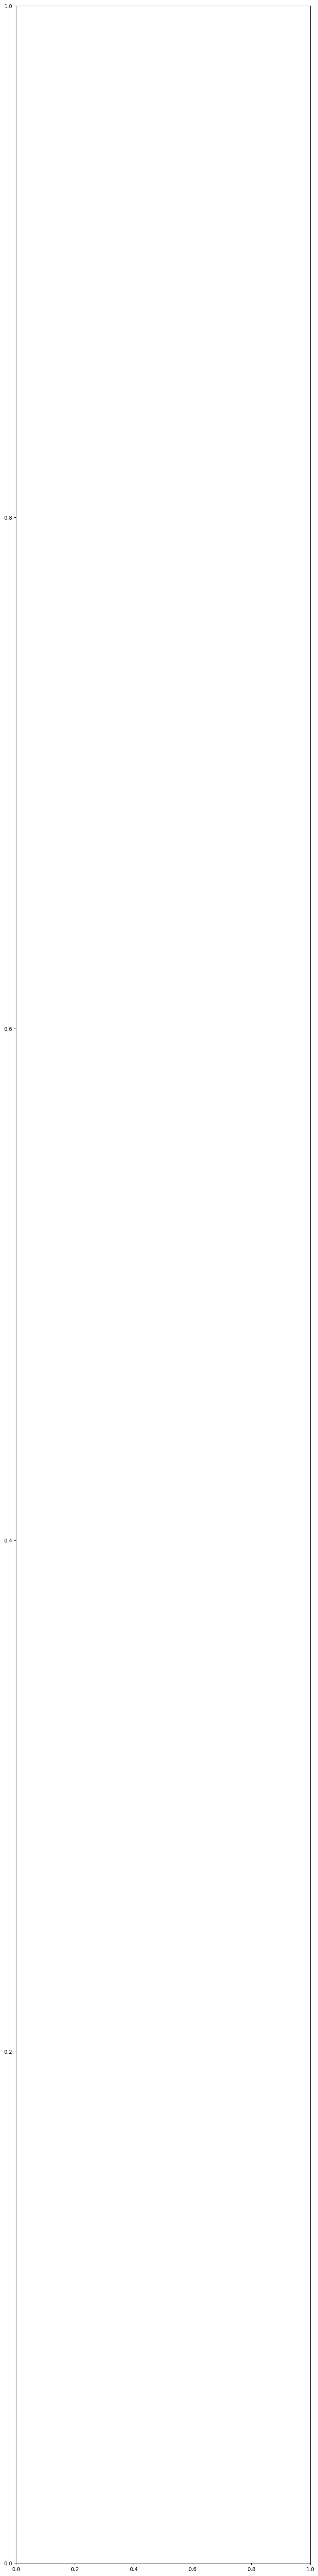

In [14]:
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])

In [15]:
ax.axis('off')

(0.0, 1.0, 0.0, 1.0)

In [16]:
ax.imshow(im_data, interpolation='nearest')

In [18]:
fig.savefig('test.png', dpi=dpi, transparent=True)

#### Training test

In [5]:
ds_path = "/home/data_backup/Downloads/archive/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/train400Xpng"

In [7]:
dcgan1 = DCGAN(ds_path, (184, 280), 3, 32, disc_update_multi=5)

Found 1820 files belonging to 1 classes.


2023-01-26 12:09:14.363534: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 12:09:14.371032: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 12:09:14.371237: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 12:09:14.372204: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [28]:
dcgan1.model_params()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 32)]         0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 3220)         103040      ['input_11[0][0]']               
                                                                                                  
 reshape_10 (Reshape)           (None, 46, 70, 1)    0           ['dense_10[0][0]']               
                                                                                                  
 conv2d_65 (Conv2D)             (None, 46, 70, 64)   128         ['reshape_10[0][0]']             
                                                                                           

                                                                                                  
 conv2d_74 (Conv2D)             (None, 92, 140, 32)  4640        ['add_22[0][0]']                 
                                                                                                  
 leaky_re_lu_22 (LeakyReLU)     (None, 92, 140, 32)  0           ['conv2d_74[0][0]']              
                                                                                                  
 conv2d_75 (Conv2D)             (None, 92, 140, 32)  9248        ['leaky_re_lu_22[0][0]']         
                                                                                                  
 leaky_re_lu_23 (LeakyReLU)     (None, 92, 140, 32)  0           ['conv2d_75[0][0]']              
                                                                                                  
 conv2d_76 (Conv2D)             (None, 92, 140, 32)  9248        ['leaky_re_lu_23[0][0]']         
          

In [29]:
dcgan1.train(20,'./imgs')
dcgan1.save_weights('./weights/g_test.ckpt', './weights/d_test.ckpt')

2023-01-25 18:42:08.286205: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 201.25MiB (rounded to 211025920)requested by op generator_6/conv2d_transpose_11/conv2d_transpose
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-01-25 18:42:08.286307: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2023-01-25 18:42:08.286340: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 444, Chunks in use: 444. 111.0KiB allocated for chunks. 111.0KiB in use in bin. 48.9KiB client-requested in use in bin.
2023-01-25 18:42:08.286360: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.


2023-01-25 18:42:18.292505: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 201.25MiB (rounded to 211025920)requested by op generator_6/conv2d_transpose_11/conv2d_transpose_1
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-01-25 18:42:18.292597: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2023-01-25 18:42:18.292631: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 444, Chunks in use: 444. 111.0KiB allocated for chunks. 111.0KiB in use in bin. 48.9KiB client-requested in use in bin.
2023-01-25 18:42:18.292651: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin

ResourceExhaustedError: Graph execution error:

Detected at node 'generator_6/conv2d_transpose_11/conv2d_transpose' defined at (most recent call last):
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_9047/1841161105.py", line 1, in <cell line: 1>
      dcgan1.train(20,'./imgs')
    File "/tmp/ipykernel_9047/636793352.py", line 111, in train
      g_l, d_l = self.update(img_b, True)
    File "/tmp/ipykernel_9047/636793352.py", line 76, in update
      g_z_1 = self.g(noise_input1)
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/tmp/ipykernel_9047/3222655541.py", line 86, in call
      x = self.us2(x)
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/site-packages/keras/layers/convolutional/conv2d_transpose.py", line 275, in call
      outputs = backend.conv2d_transpose(
    File "/home/data_backup/miniconda3/envs/gan/lib/python3.9/site-packages/keras/backend.py", line 5756, in conv2d_transpose
      x = tf.compat.v1.nn.conv2d_transpose(x, kernel, output_shape, strides,
Node: 'generator_6/conv2d_transpose_11/conv2d_transpose'
OOM when allocating tensor with shape[64,16,184,280] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node generator_6/conv2d_transpose_11/conv2d_transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_update_34677]

In [15]:
dcgan1.load_weights('./weights/g_test.ckpt', './weights/d_test.ckpt')

Loaded generator weights
Loaded discriminator weights


In [9]:
dcgan1.generate_samples(10, './samples/0')

In [22]:
dcgan2 = DCGAN(ds_path, (32, 32), 1, 25, disc_update_multi=1)

Found 61115 files belonging to 10 classes.


In [23]:
dcgan2.load_weights('./weights/g_test.ckpt', './weights/d_test.ckpt')

Loaded generator weights
Loaded discriminator weights


In [24]:
dcgan2.train(20, './imgs')

Epoch 0000 Generator Avg. Loss:  4.135277 , Discriminator Avg. Loss:  -24.857014
Epoch 0001 Generator Avg. Loss:  4.6134653 , Discriminator Avg. Loss:  -25.13239
Epoch 0002 Generator Avg. Loss:  4.0988293 , Discriminator Avg. Loss:  -25.00547
Epoch 0003 Generator Avg. Loss:  2.7498639 , Discriminator Avg. Loss:  -24.820496
Epoch 0004 Generator Avg. Loss:  2.7494276 , Discriminator Avg. Loss:  -25.517073
Epoch 0005 Generator Avg. Loss:  2.5572271 , Discriminator Avg. Loss:  -25.775757
Epoch 0006 Generator Avg. Loss:  2.8540509 , Discriminator Avg. Loss:  -25.298714
Epoch 0007 Generator Avg. Loss:  1.8396221 , Discriminator Avg. Loss:  -25.289017
Epoch 0008 Generator Avg. Loss:  1.7446529 , Discriminator Avg. Loss:  -25.202993
Epoch 0009 Generator Avg. Loss:  2.024638 , Discriminator Avg. Loss:  -25.576641
Epoch 0010 Generator Avg. Loss:  -0.21806537 , Discriminator Avg. Loss:  -25.628574
Epoch 0011 Generator Avg. Loss:  1.4440452 , Discriminator Avg. Loss:  -25.73827
Epoch 0012 Generato

KeyboardInterrupt: 

In [55]:
dcgan2.save_weights('./weights/g_test.ckpt', './weights/d_test.ckpt')

Saved generator weights
Saved discriminator weights


In [56]:
dcgan1.load_weights('./weights/g_test.ckpt', './weights/d_test.ckpt')

Loaded generator weights
Loaded discriminator weights


In [58]:
dcgan3 = DCGAN(None, (32, 32), 1, 25, disc_update_multi=1)

In [60]:
dcgan3.load_weights('./weights/g_test.ckpt', './weights/d_test.ckpt')

Loaded generator weights
Loaded discriminator weights


In [61]:
dcgan3.generate_samples(10, './samples/1')

### Pre-Act Resblk Generator

In [3]:
class Generator(Model):

    def __init__(self, noise_dim, image_shape, num_channel):
        super().__init__()
        
        assert len(image_shape) == 2
        assert image_shape[0]%4 == 0
        assert image_shape[1]%4 == 0
        
        self.noise_dim = noise_dim
        self.image_shape = image_shape
        self.num_channel = num_channel
        self.kernel_size = 3
        
        # add layer(multiple for plot clarification)
        self.add1 = layers.Add()
        self.add2 = layers.Add()
        
        # init layers
        self.init_dense = layers.Dense(image_shape[0]/4.0*image_shape[1]/4.0,
                               use_bias=False, input_shape=(None, self.noise_dim), activation='relu')
        
        self.init_reshape = layers.Reshape((int(image_shape[0]/4.0), int(image_shape[1]/4.0),1))
        
        # in conv 1x1
        self.in_conv11 = layers.Conv2D(64, (1, 1),
                                strides=(1, 1), padding='same')
        
        # resblk 1
        self.rb1_in1 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb1_rl1 = layers.ReLU()
        self.rb1_conv2d1 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb1_in2 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb1_rl2 = layers.ReLU()
        self.rb1_conv2d2 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # upsample 1
        self.us1 = layers.Conv2DTranspose(32, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        
        # resblk2
        self.rb2_in1 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb2_rl1 = layers.ReLU()
        self.rb2_conv2d1 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb2_in2 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb2_rl2 = layers.ReLU()
        self.rb2_conv2d2 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # upsample 2
        self.us2 = layers.Conv2DTranspose(16, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        
        # out conv 1x1
        self.out_conv11 = layers.Conv2D(self.num_channel, (1, 1),
                                        strides=(1, 1), padding='same', activation='tanh')

    def call(self, noise_vec):
        
        # in
        x = self.init_reshape(self.init_dense(noise_vec))
#         x = self.init_reshape(noise_vec)
        
        # conv 1x1
        x = self.in_conv11(x)
        
        # resblk 1
        x_res = self.rb1_conv2d1(self.rb1_rl1(self.rb1_in1(x)))
        x_res = self.rb1_conv2d2(self.rb1_rl2(self.rb1_in2(x_res)))
        x = self.add1([x, x_res])
        
        # upsample 1
        x = self.us1(x)
        
        # resblk 2
        x_res = self.rb2_conv2d1(self.rb2_rl1(self.rb2_in1(x)))
        x_res = self.rb2_conv2d2(self.rb2_rl2(self.rb2_in2(x_res)))
        x = self.add2([x, x_res])
        
        # upsample 2
        x = self.us2(x)
        
        # conv 1x1
        x = self.out_conv11(x)
        
        return x

    def build_graph(self):
        x = layers.Input(shape=(self.noise_dim,))
        
        return Model(inputs=x, outputs=self.call(x))
        

In [4]:
g1 = Generator(10, (32, 32), 3)

2022-09-15 17:02:14.509813: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 17:02:14.515718: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 17:02:14.515817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 17:02:14.516122: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
noise_input = tf.random.normal((5, 10))

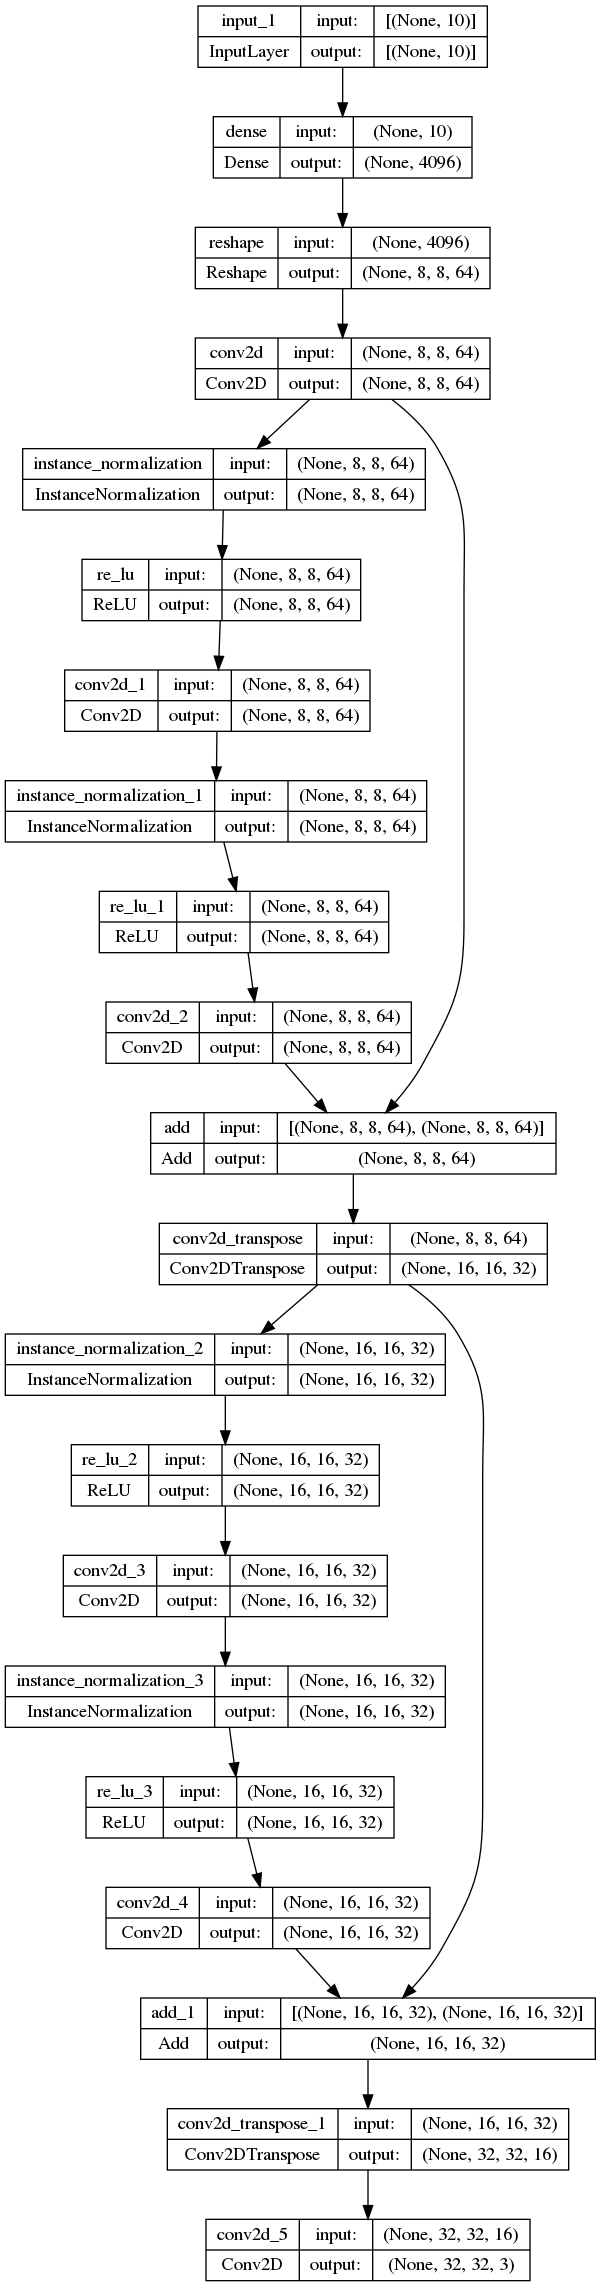

In [6]:
tf.keras.utils.plot_model(g1.build_graph(), show_shapes=True)

In [27]:
g1.build_graph().summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 4096)         40960       ['input_7[0][0]']                
                                                                                                  
 reshape_5 (Reshape)            (None, 8, 8, 64)     0           ['dense_5[1][0]']                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 8, 8, 64)     4160        ['reshape_5[1][0]']              
                                                                                            

### Pre-Act Resblk Discriminator

In [2]:
class Discriminator(Model):

    def __init__(self, image_shape, num_channel):
        super().__init__()
        
        assert len(image_shape) == 2
        
        self.image_shape = image_shape
        self.num_channel = num_channel
        self.kernel_size = 3
        
        # add layer(multiple for plot clarification)
        self.add1 = layers.Add()
        self.add2 = layers.Add()
        
        
        # in conv 1x1
        self.in_conv11 = layers.Conv2D(16, (1, 1),
                                        strides=(1, 1), padding='same',
                                        input_shape=(None, self.image_shape[0],
                                        self.image_shape[1], self.num_channel))
        
        # resblk 1 
        self.rb1_rl1 = layers.LeakyReLU()
        self.rb1_conv2d1 = layers.Conv2D(16, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb1_rl2 = layers.LeakyReLU()
        self.rb1_conv2d2 = layers.Conv2D(16, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # downsample 1
        self.ds1 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        
        # resblk 2
        self.rb2_rl1 = layers.LeakyReLU()
        self.rb2_conv2d1 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb2_rl2 = layers.LeakyReLU()
        self.rb2_conv2d2 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # downsample 2
        self.ds2 = layers.Conv2D(8, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        
        # reshape for linear act
        self.rs_out = layers.Reshape((int(self.image_shape[0]/4.0)*int(self.image_shape[1]/4.0)*8,))
        
        # out
        self.dense_actv = layers.Dense(8)

        
        
    def call(self, img_input):
        # in
        x = self.in_conv11(img_input)
        
        # resblk 1
        x_res = self.rb1_conv2d1(self.rb1_rl1(x))
        x_res = self.rb1_conv2d2(self.rb1_rl2(x_res))
        x = self.add1([x, x_res])
        
        # resblk 1 downsample
        x = self.ds1(x)
        
        # resblk 2
        x_res = self.rb2_conv2d1(self.rb2_rl1(x))
        x_res = self.rb2_conv2d2(self.rb2_rl2(x_res))
        x = self.add2([x, x_res])
        
        # resblk 2 downsample
        x = self.ds2(x)
        
        # reshape
        x = self.rs_out(x)
        
        # out
        x = self.dense_actv(x)

        return x
    
    def build_graph(self):
        x = layers.Input(shape=(self.image_shape[0],
                                        self.image_shape[1], self.num_channel))
        
        return Model(inputs=x, outputs=self.call(x))
        

In [8]:
d1 = Discriminator((160, 120), 3)

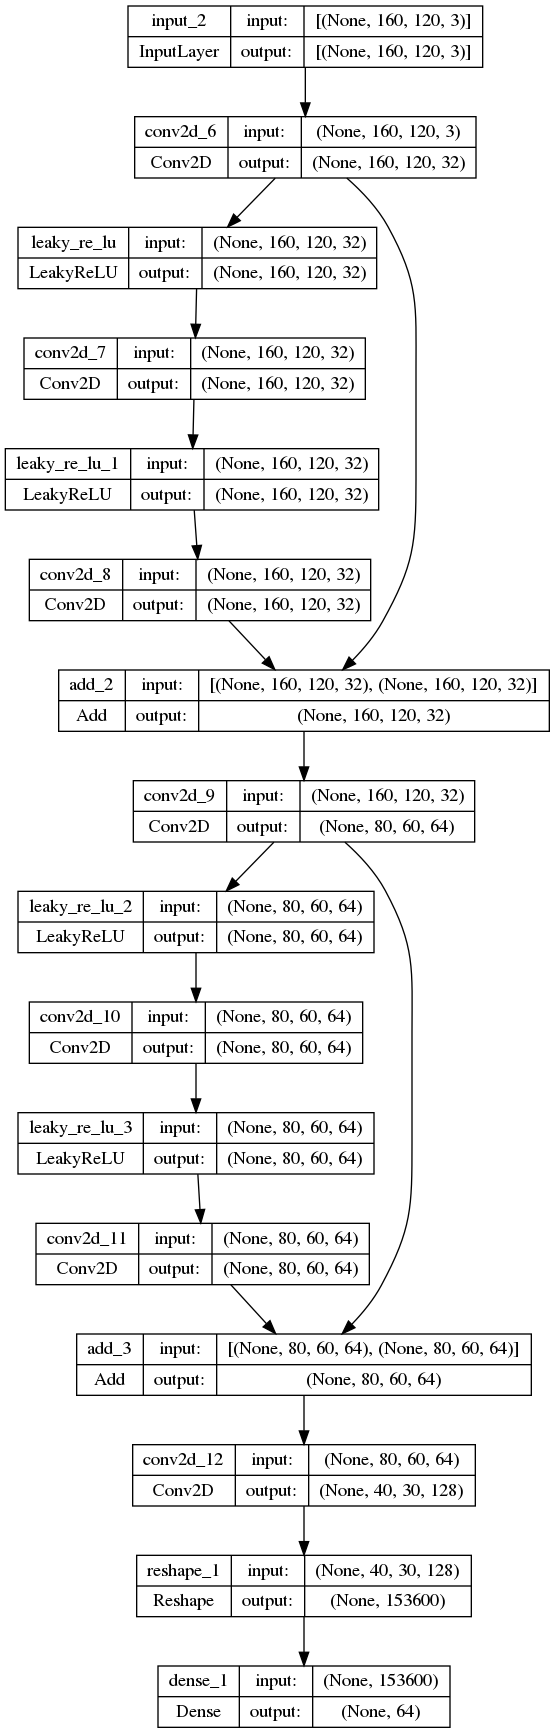

In [9]:
tf.keras.utils.plot_model(d1.build_graph(), show_shapes=True)

In [10]:
d1.build_graph().summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 160, 120, 32  128         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 160, 120, 32  0           ['conv2d_6[1][0]']               
                                )                                                           